In [1]:
import requests
import json
import os
import google.generativeai as genai

GEMINI_API_KEYS = [
    
]

REQUESTS_PER_KEY_PER_DAY = 20
RESET_TIME = 60*10

with open('../source/wines.txt',encoding='utf-8') as f:
    TEXT_INPUT = ''.join(f.readlines())

with open('../source/regions.txt',encoding='utf-8') as f:
    TEXT_INPUT += ''.join(f.readlines())

PROMPT = r"""
# Цель
Тебе на вход даётся текстовый документ в формате Latex. Сначала выдели все сущности, которые необходимы, чтобы передать всю содержащуются в тексте информацию и идеи. Далее, найди все связи между этими сущностями в тексте. Также найди связи между обнаруженными сущностями в тексте и контекстом - набор сущностей и связей, котоырй был извлечен в предыдущей итерации работы над другой частью этого текста.

{context}

# Шаги
1. Выдели все сущности. Для каждой найденной сущности, укажи:
- entity_name: Имя сущности, заглавными буквами
- entity_type: Предложи несколько категорий для сущности. Категории не должны быть конкретными, а должны быть наиболее общими. 
- entity_description: Подробное описание атрибутов сущности.
Не используй кавычки и другие знаки препинания в имени сущности. Удаляй лишние кавычки.
Выведи информацию о сущности в следующем виде (entity|<entity_name>|<entity_type>|<entity_description>)

2. Для всех сущностей, выделенных на шаге 1, выдели все связи, т.е. пары (исходная_сущность, целевая_сущность) которые *связаны* между собой.
Для каждой пары связанных сущностей, извлеки следующую информацию:
- source_entity: имя исходной сущности, как она найдена на шаге 1
- target_entity: имя целевой сущности, как она найдена на шаге 1
- relationship_name: короткое имя связи между сущностями
- relationship_description: описание того, как исходная сущность и целевая сущность связаны между собой. В связах могут участвовать только сущности, выделенные на шаге 1. 
 Выведи информацию о связях в следующем виде (relationship|<source_entity>|<target_entity>|<relationship_name>|<relationship_description>)

3. Выведи результат в виде списка, содержащего все сущности, найденные на шаге 1, и связи, найденные на шаге 2. Используй **перевод строки** как разделитель списка.

4. Когда закончишь, выведи [EOF]

######################
-Примеры-
######################
Текст:
Борщ — горячий заправочный суп на основе свёклы, которая придаёт ему характерный красный цвет.
В словаре В. И. Даля — род щей, похлёбка из квашеной свёклы, на говядине и свинине, или со свиным салом. Получило широкое распространение во многих национальных кухнях: это блюдо есть у русских, белорусов и др.
######################
Результат:
(entity|БОРЩ|БЛЮДО|горячий заправочный суп на основе свёклы)
(entity|ГОВЯДИНА|ИНГРЕДИЕНТ|Мясо коровы, входящее в состав борща)
(entity|СВИНИНА|ИНГРЕДИЕНТ|Мясо свиньи, входящее в состав борща)
(entity|ЩИ|БЛЮДО|вид первого блюда)
(entity|РУССКИЕ|НАРОД|проживающие в России)
(entity|БЕЛОРУСЫ|НАРОД|проживающие в Белоруссии)
(relationship|БОРЩ|ЩИ|ЧАСТНЫЙ_СЛУЧАЙ|Борщ является разновидностью Щей)
(relationship|БОРЩ|ГОВЯДИНА|СОДЕРЖИТ|Борщ может содержать говядину)
(relationship|БОРЩ|СВИНИНА|СОДЕРЖИТ|Борщ может содержать свинину)
(relationship|БОРЩ|РУССКИЕ|РАСПРОСТРАНЕНИЕ|Борщ распространён у русских)
(relationship|БОРЩ|БЕЛОРУСЫ|РАСПРОСТРАНЕНИЕ|Борщ распространён у белорусов)
[EOF]
######################
Текст:
Цифровой рубль  — цифровая валюта центрального банка, разрабатываемая Банком России (ЦБ РФ), третья форма российской национальной валюты в дополнение к уже существующим наличной и безналичной формам денег.
Цифровой рубль будет эмитироваться Банком России. Цифровой рубль сочетает в себе свойства наличных и безналичных рублей.
######################
Результат:
(entity|ЦИФРОВОЙ_РУБЛЬ|ВАЛЮТА|цифровая валюта центрального банка)
(entity|БАНК РОССИИ|БАНК|Центральный банк России)
(entity|НАЛИЧНАЯ|ФОРМА ДЕНЕГ|Деньги, распространяемые купюрами)
(entity|БЕЗНАЛИЧНАЯ|ФОРМА ДЕНЕГ|Деньги, распространяемые в электронном виде)
(relationship|ЦИФРОВОЙ РУБЛЬ|БАНК РОССИИ|ЭМИТИРУЕТСЯ|Цифровой рубль будет эмитироваться Банком России)
(relationship|ЦИФРОВОЙ РУБЛЬ|НАЛИЧНАЯ|ИМЕЕТ_СВОЙСТВА|Цифровой рубль имеет свойста наличных денег)
(relationship|ЦИФРОВОЙ РУБЛЬ|БЕЗНАЛИЧНАЯ|ИМЕЕТ_СВОЙСТВА|Цифровой рубль имеет свойста безналичных денег)
######################
-Реальные данные-
######################
Текст: {text}
######################
Результат:
"""

In [2]:
def process_text_gemini(prompt: str, key: str):
    try:
        genai.configure(api_key=key)
        llm = genai.GenerativeModel("gemini-1.5-pro")
        response = llm.generate_content(prompt)
        return response.text
    except Exception as e:
        if "429" in str(e):
            return "Error request 429"
        else:
            print(f"Error with Gemini: {e}")
            return None

def save_response_to_json(response: str, filename: str, output_dir: str):
    if response is None:
        print(f"Файл {filename} не будет сохранён ввиду пустого запроса.")
        return

    filepath = os.path.join(output_dir, filename)
    os.makedirs(output_dir, exist_ok=True)
    with open(filepath, "w", encoding="utf-8") as f:
        if "processed" in output_dir:
            json.dump(response, f, ensure_ascii=False, indent=4)
        else:
            json.dump({"model_response": response}, f, ensure_ascii=False, indent=4)

In [3]:
import unicodedata

ACCENT_MAPPING = {
    '́': '',
    '̀': '',
    'а́': 'а',
    'а̀': 'а',
    'е́': 'е',
    'ѐ': 'е',
    'и́': 'и',
    'ѝ': 'и',
    'о́': 'о',
    'о̀': 'о',
    'у́': 'у',
    'у̀': 'у',
    'ы́': 'ы',
    'ы̀': 'ы',
    'э́': 'э',
    'э̀': 'э',
    'ю́': 'ю',
    '̀ю': 'ю',
    'я́́': 'я',
    'я̀': 'я',
}
ACCENT_MAPPING = {unicodedata.normalize('NFKC', i): j for i, j in ACCENT_MAPPING.items()}


def unaccentify(s):
    source = unicodedata.normalize('NFKC', s)
    for old, new in ACCENT_MAPPING.items():
        source = source.replace(old, new)
    return source

def normalize(text):
    return (unaccentify(text)
            .replace('«','')
            .replace('»','')
            .replace('"','')
            .replace('<','')
            .replace('>',''))

In [4]:
import re

def add_entity(entities,name,kind,desc):
    if name in entities.keys():
        entities[name]['kind'].append(kind)
        entities[name]['desc'].append(desc)
    else:
        entities[name] = { 'kind' : [kind], 'desc' : [desc] }

def extract_ER(lines):
    entities = {}
    relations = []
    for x in lines:
        x = normalize(x)
        if z:=re.match(r'\((.*)\)',x):
            z = z.string.strip()[1:-1].split('|')
            z = [t.strip().lower() for t in z]
            if z[0] == 'entity':
                if len(z)<4:
                    z.append('')
                else:
                    add_entity(entities, z[1], z[2], z[3])
            elif z[0] == 'relationship':
                while len(z)<5:
                    z.append('')
                relations.append({ 
                    "source": z[1], 
                    "target" : z[2], 
                    "relation": z[3],
                    "desc" : z[4]})
            else:
                print(f'Неверная команда: {z}')
    relations = [x for x in relations if x['source'] in entities.keys() and x['target'] in entities.keys()]
    
    return entities, relations

In [5]:
import networkx as nx
import matplotlib.pyplot as plt


def plot_graph(G):
    plt.figure(figsize=(20,20))
    pos = nx.spring_layout(G)
    
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=12)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))
    
    plt.show()

def create_and_plot_graph(entities, relations, filename="graph.png", output_dir="graphs"):
    G = nx.DiGraph()
    exist_entities = set([r['source'] for r in relations] + [r['target'] for r in relations])

    for e, v in entities.items():
        if e in exist_entities:
            G.add_node(e, label=e)

    for r in relations:
        G.add_edge(r['source'], r['target'], label=r['relation'], desc=r['desc'])

    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=12)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))

    filepath = os.path.join(output_dir, filename)
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(filepath)
    plt.close()

In [6]:
import tiktoken
from tqdm import tqdm
import time

MAX_TOKENS = 8000
ENCODING = tiktoken.encoding_for_model("gpt-3.5-turbo")

def count_tokens(text):
    return len(ENCODING.encode(text))

def chunk_text(text, max_tokens=MAX_TOKENS):
    tokens = ENCODING.encode(text)
    chunks = []
    current_chunk = []

    for token in tokens:
        current_chunk.append(token)
        if len(ENCODING.decode(current_chunk)) >= max_tokens :
            chunks.append(ENCODING.decode(current_chunk[:-1]))
            current_chunk = [token]


    chunks.append(ENCODING.decode(current_chunk))
    return chunks

def format_context(entities, relations):
    context = "Ранее извлеченные сущности и связи:\n"
    if entities:
        context += "Entities:\n"
        for entity, data in entities.items():
            context += f"- {entity} (Types: {', '.join(data['kind'])})\n"
    if relations:
        context += "Relations:\n"
        for relation in relations:
            context += f"- {relation['source']} --{relation['relation']}--> {relation['target']}\n"
    return context

def process_text_with_context(text_chunks, prompt_template, context_cache=None, api_keys=GEMINI_API_KEYS, intermediate_filename="intermediate_results.json"):
    all_entities = {}
    all_relations = []

    api_key_index = 0
    requests_count = 0

    if os.path.exists(intermediate_filename):
        with open(intermediate_filename, "r", encoding="utf-8") as f:
            intermediate_data = json.load(f)
            all_entities = intermediate_data["entities"]
            all_relations = intermediate_data["relations"]
            start_chunk_index = intermediate_data["last_processed_chunk"]
    else:
       start_chunk_index = 0

    for i in tqdm(range(start_chunk_index, len(text_chunks)), desc="Processing chunks", unit="chunk", initial=start_chunk_index, total=len(text_chunks)):
        chunk = text_chunks[i]
        
        if context_cache:
            cache_key = f"chunk_{i}"
            if cache_key in context_cache:
                context, entities, relations = context_cache[cache_key]
                all_entities.update(entities)
                all_relations.extend(relations)
                continue

        if i > 0 and not context_cache: 
            context = format_context(all_entities, all_relations)
        else:
            context = ""

        prompt = prompt_template.format(text=chunk, context=context)
        
        current_api_key = api_keys[api_key_index]
        while True:
            response = process_text_gemini(prompt=prompt, key=current_api_key)
            if response == "Error request 429":
                time_remaining = RESET_TIME - (time.time() % RESET_TIME)
                print(f"Достигнут лимит запросов. Запущен сонный режим на {time_remaining:.1f} секунд...")
                time.sleep(time_remaining + 60)
                continue
            elif response is None:
                print(f"Возникла ошибка при запросе в Gemini. Завершение обработки.")
                return all_entities, all_relations
            else:
                break
                    
        requests_count += 1
        if requests_count >= REQUESTS_PER_KEY_PER_DAY:
            api_key_index = (api_key_index + 1) % len(api_keys)
            requests_count = 0

        if response:
            lines = response.strip().split('\n')
            entities, relations = extract_ER(lines)
            all_entities.update(entities)
            all_relations.extend(relations)

            if context_cache:
                context_cache[cache_key] = (context, entities, relations)
                
        intermediate_data = {"entities": all_entities, "relations": all_relations, "last_processed_chunk": i + 1} # Save after EACH chunk.
        with open(intermediate_filename, "w", encoding="utf-8") as f:
            json.dump(intermediate_data, f, ensure_ascii=False, indent=4)



    return all_entities, all_relations

In [7]:
def process_and_save_all(text: str, prompt_template: str, context_cache=None):
    raw_dir = "raw_responses"
    processed_dir = "processed_responses"
    graphs_dir = "graphs"

    text_chunks = chunk_text(text)

    entities, relations = process_text_with_context(text_chunks, prompt_template, context_cache=context_cache)
        
    response_text = "\n".join(f"(entity|{entity}|{', '.join(data['kind'])}|{data['desc'][0]})" for entity, data in entities.items()) + "\n" + "\n".join(f"(relation|{rel['source']}|{rel['target']}|{rel['relation']}|{rel['desc']})" for rel in relations)
    save_response_to_json(response_text, "gemini_response.json", raw_dir)
        
    processed_data = {"entities": entities, "relations": relations}
    save_response_to_json(processed_data, "gemini_processed.json", processed_dir)

    create_and_plot_graph(entities, relations, filename="gemini_graph.png", output_dir=graphs_dir)

cache = {}
process_and_save_all(TEXT_INPUT, PROMPT, cache)

Processing chunks: 100%|█████████████████████| 54/54 [20:59<00:00, 83.95s/chunk]


In [8]:
with open('processed_responses/gemini_processed.json', "r", encoding="utf-8") as f:
            data = json.load(f)
            entities, relations = data["entities"], data["relations"]

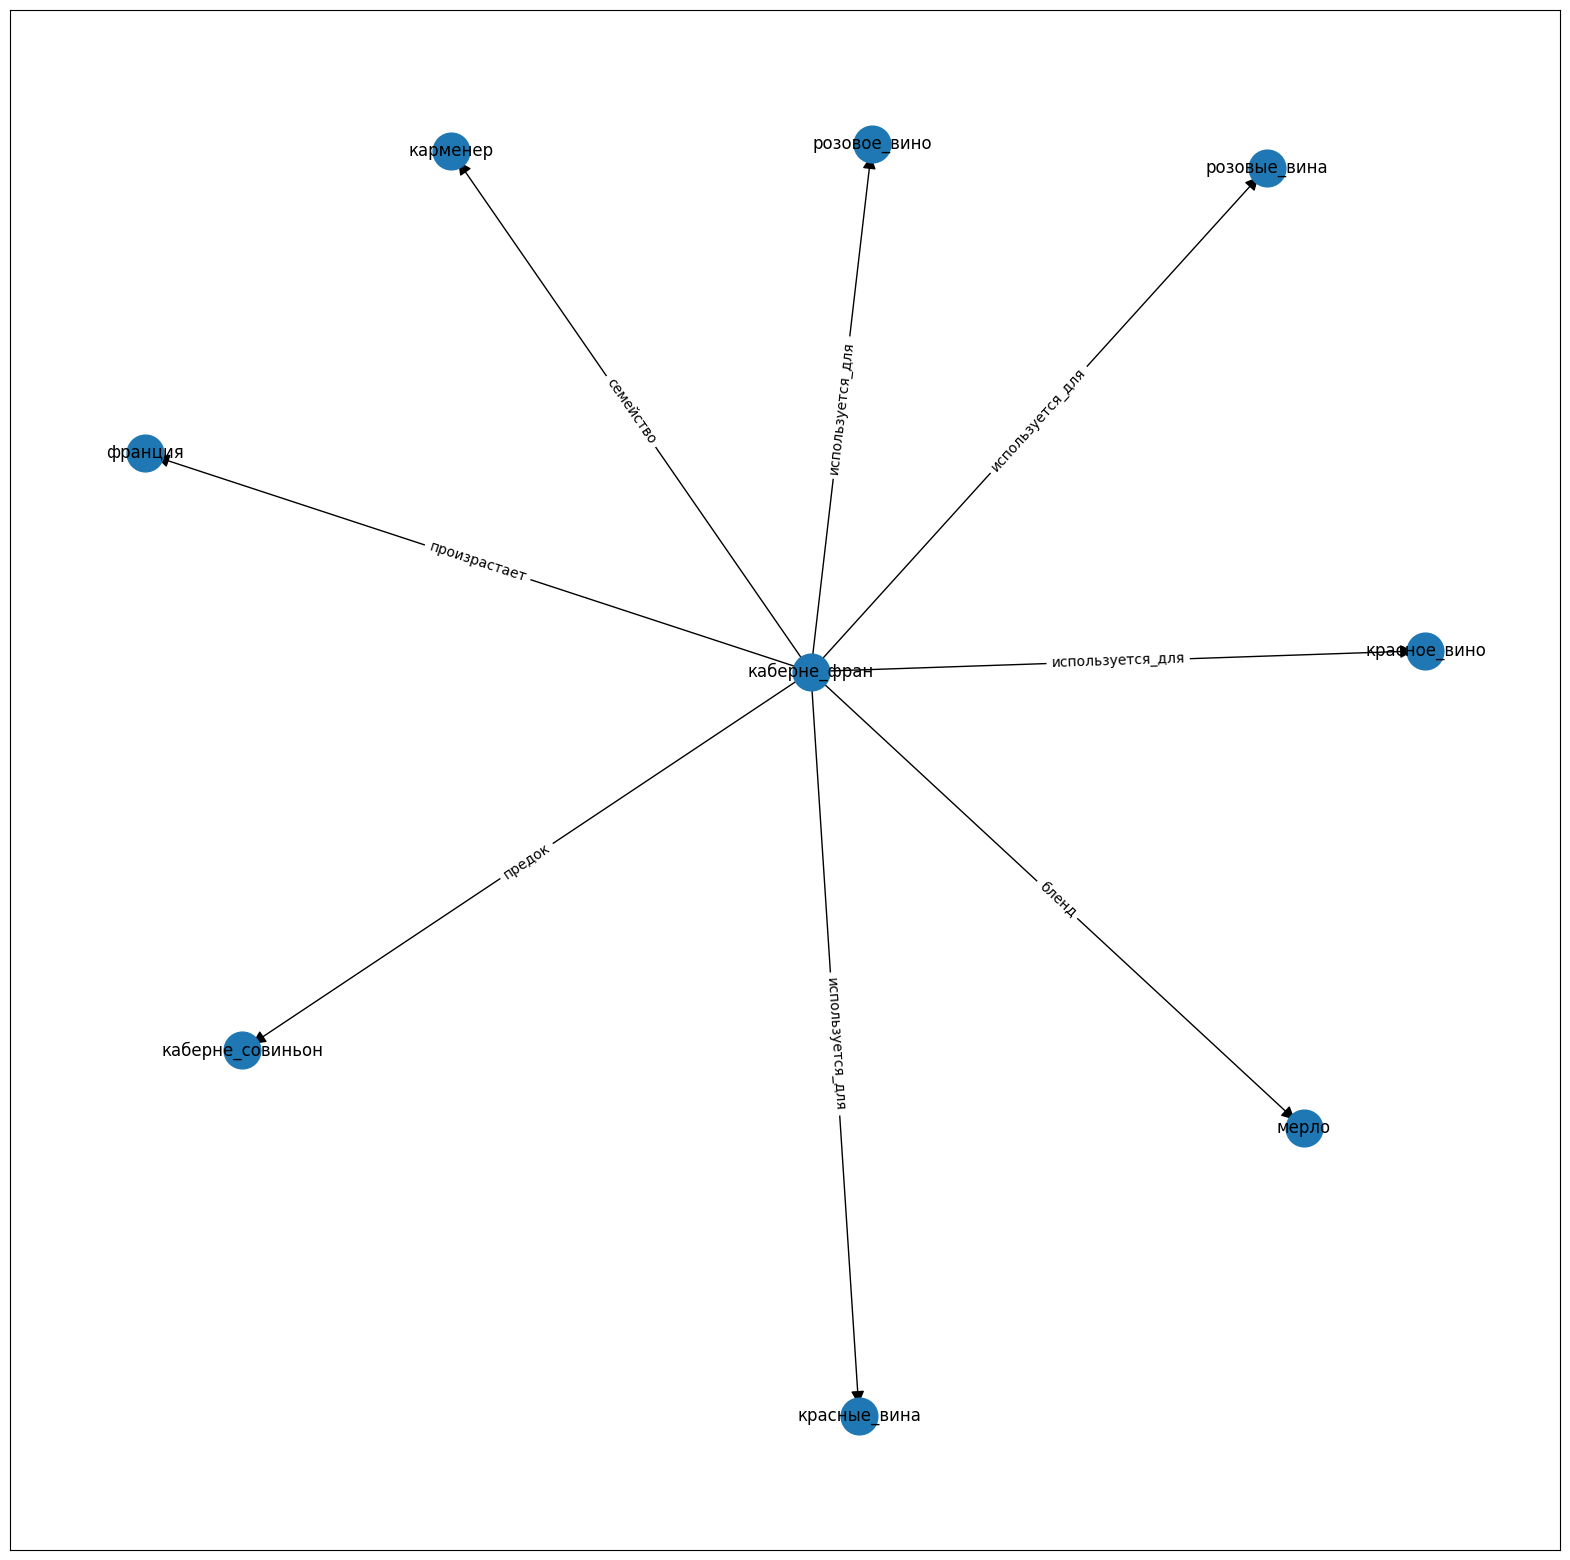

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

def populate_graph(G,e,level=None):
    if e in G.nodes:
        return
    if e in entities.keys():
        G.add_node(e, label=e)
    if level is not None and level<=0:
        return
    new_ent = set(
        [r['source'] for r in relations if r['target'] == e] + 
        [r['target'] for r in relations if r['source'] == e])
    for ne in new_ent:
        populate_graph(G,ne,None if level is None else level-1)
    for r in relations:
        if r['source'] == e:
            G.add_edge(e, r['target'], label=r['relation'], desc=r['desc'])
        if r['target'] == e:
            G.add_edge(r['source'], e, label=r['relation'], desc=r['desc'])
        
populate_graph(G,'каберне_фран',1)

plot_graph(G)

In [10]:
import os
import google.generativeai as genai

entity_lookup_prompt = """
Ниже в тройных обратных кавычках приводится короткий текст. Тебе необходимо выделить из него все сущности,
похожие на сущности из списка в двойных кавычках: "{list}". Верни только список сущностей в скобках
через запятую, например: (Яндекс, компания, директор). Верни только те сущности, которые в явном виде
присутствуют в запросе. Не придумывай никакие дополнительные сущности и не рассуждай.
--текст--
```
{}
```
""".replace('{list}',', '.join(entities.keys()))

def process_q(txt):
    try:
        genai.configure(api_key=os.environ['Gemini_api'])
        llm = genai.GenerativeModel("gemini-1.5-pro")
        res = llm.generate_content(entity_lookup_prompt.format(txt)).text
        if '(' in res and ')' in res:
            res = res[res.index('(')+1:res.index(')')]
            res = res.split(',')
            return [x.strip() for x in res]
        else:
            return None
    except Exception as e:
        print(f"Error with Gemini: {e}")
        return None

q = "Расскажи поподробнее, что ты знаешь про сорт винограда сира?"
ents = process_q(q)
print(ents)

['сира']


In [11]:
G = nx.DiGraph()
for e in ents:
    populate_graph(G,e,2)

for e in G.edges(data=True):
    print(e)

('сира', 'отлично_адаптируется', {'label': 'характеристика', 'desc': 'сира отлично адаптируется'})
('сира', 'прохладный_климат', {'label': 'адаптация', 'desc': 'сира адаптируется к прохладному климату'})
('сира', 'мондез_бланш', {'label': 'предок', 'desc': 'мондез бланш является предком сира.'})
('сира', 'долина_роны', {'label': 'происхождение', 'desc': 'сира происходит из долины роны.'})
('сира', 'вина', {'label': 'дает', 'desc': 'из сиры получаются вина'})
('сира', 'австралия', {'label': 'выращивается', 'desc': 'сира выращивается в австралии.'})
('сира', 'теплый_климат', {'label': 'адаптация', 'desc': 'сира адаптируется к теплому климату'})
('сира', 'шираз', {'label': 'синоним', 'desc': 'сира и шираз - синонимы.'})
('сира', 'дурез', {'label': 'предок', 'desc': 'дурез является предком сира.'})
('сира', 'овернь_рона_альпы', {'label': 'происхождение', 'desc': 'сира предположительно произошла из региона овернь-рона-альпы.'})
('вашингтон', 'сша', {'label': 'расположение', 'desc': 'вашингт

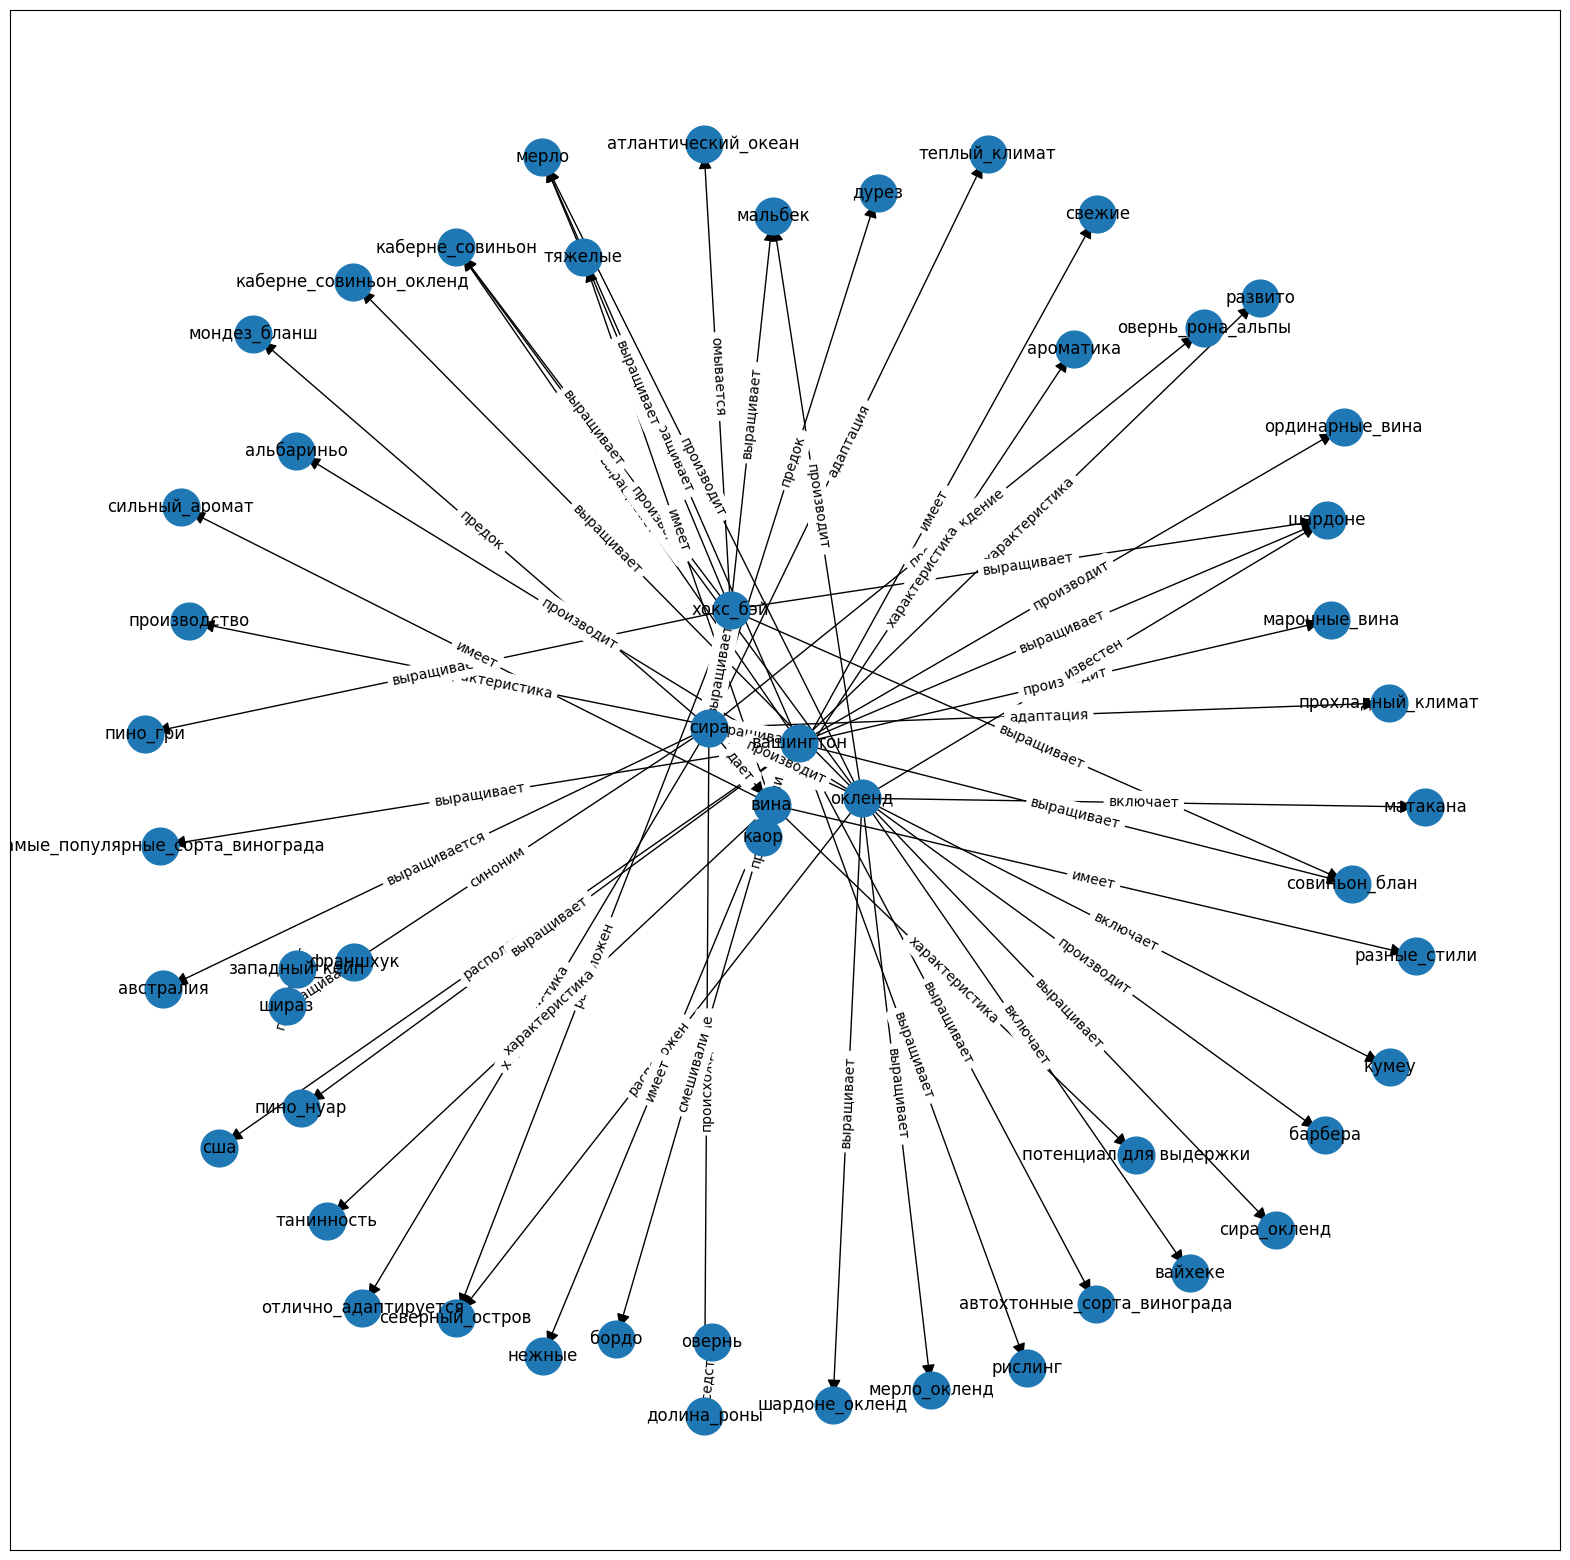

In [12]:
plot_graph(G)

In [13]:

answer_prompt = """
Тебе задан следующий запрос от пользователя: {question}.
Ответь на этот вопрос, используя при этом информацию, содержащуюся ниже в тройных обратных кавычках:
```
{context}
```
"""

def create_context(G):
    return '\n'.join(
        e[-1]['desc'] for e in G.edges(data=True))

try:
    genai.configure(api_key=os.environ['Gemini_api'])
    llm = genai.GenerativeModel("gemini-1.5-pro")  # or the model you're using
    response = llm.generate_content(answer_prompt
    .replace('{context}',create_context(G))
    .replace('{question}',q)).text
    print(response)
except Exception as e:
    print(f"Error with Gemini answer: {e}")

Сира (или Шираз, это синонимы) – сорт винограда с богатой историей и широкой географией культивирования.  Предположительно, он происходит из французского региона Овернь-Рона-Альпы, точнее, из долины Роны, что подтверждается близостью Оверни к этой долине.  Интересно, что предками Сиры считаются сорта Мондез Бланш и Дюрез.

Сира демонстрирует отличную adaptability к различным климатическим условиям, как тёплым, так и прохладным.  Это объясняет его распространенность по всему миру.  Например, Сира успешно выращивают в таких разных регионах, как Австралия, штат Вашингтон (США), Новая Зеландия (регионы Хокс-Бэй и Окленд).

Из винограда Сира производят вина разных стилей – от лёгких и свежих до тяжёлых, с сильным ароматом и большим потенциалом к выдержке.

